## Домашнее задание 3 (10 баллов)

## НИУ ВШЭ, 2023-24 учебный год

## О задании

1. Любой график имеет название.
2. Оси у графика подписаны (исключение - график делит название оси с соседним).
3. Подписи делаются на одном языке.
4. Если вы выводите несколько графиков, то они размещаются в рамках одного объекта matplotlib.pyplot.figure. Вы не выводите графики последовательно, а смотрите, как их разместить сразу все за раз.
5. Отдельные графики (если графиков на картинке больше 1) также имеют свои названия.
6. Если на графике есть несколько различных объектов, то для их различения используется легенда.
7. Если есть легенда, то она должна иметь навание, а также ее содержание должно быть адекватными.
8. Используйте цветовые гаммы, чтобы объекты на графиках отличались цветом.
9. Текст на визуализации должен быть читаем. Если вы вывели названия категорий в качестве подписей на оси Х, а эти названия наезжают друг на друга, то вам нужно что-то с этим сделать.

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones). 

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна

Вероятно, сначала покажется сложным, но мы разберемся с некоторыми признаками в отдельности и вы сможете понять их смысл, уже исходя из фактических соотношений.

## Предобработка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [3]:
train.shape

(7352, 563)

В датасете 563 признака, включая целевую переменную. Столько признаков нам не нужно. Мы за вас сделали подвыборку признаков для удобства работы с ними.

In [6]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [27]:
train = train[cols_subset]
test = test[cols_subset]

In [28]:
test.shape

(2947, 11)

In [4]:
df = pd.concat([train, test])
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [8]:
train.head()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,Activity
0,-0.959434,-0.992165,0.977436,-0.934724,-0.993592,-0.841247,0.179941,-0.058627,0.142051,1,STANDING
1,-0.979289,-0.989876,0.984520,-0.943068,-0.998235,-0.844788,0.180289,-0.054317,-0.692541,1,STANDING
2,-0.983703,-0.987868,0.986770,-0.938692,-0.999388,-0.848933,0.180637,-0.049118,-0.727227,1,STANDING
3,-0.986542,-0.991241,0.986821,-0.938692,-0.999807,-0.848649,0.181935,-0.047663,-0.599118,1,STANDING
4,-0.992827,-0.992882,0.987434,-0.942469,-0.999806,-0.847865,0.185151,-0.043892,-0.676997,1,STANDING


### Задание 1 (0.5 балла)

Посмотрите на пропуски и дубли в данных train и test. Есть ли они? Если есть, напишите, с чем это может быть связано? Если нет, то просто напишите, что пропусков и/или дублей нет.

# ٩(◕‿◕｡)۶ 

In [10]:
train.isna().sum()

tBodyAccMag-mean()              0
tBodyGyroJerk-mad()-X           0
tGravityAcc-min()-X             0
tBodyAcc-max()-X                0
fBodyAcc-bandsEnergy()-1,8.2    0
angle(X,gravityMean)            0
angle(Y,gravityMean)            0
angle(Z,gravityMean)            0
fBodyAcc-skewness()-X           0
subject                         0
Activity                        0
dtype: int64

In [13]:
test.isna().sum()

tBodyAccMag-mean()              0
tBodyGyroJerk-mad()-X           0
tGravityAcc-min()-X             0
tBodyAcc-max()-X                0
fBodyAcc-bandsEnergy()-1,8.2    0
angle(X,gravityMean)            0
angle(Y,gravityMean)            0
angle(Z,gravityMean)            0
fBodyAcc-skewness()-X           0
subject                         0
Activity                        0
dtype: int64

Пропусков нет!

### Задание 2 (0.5 балла)

Выведите основные статистики данных: среднее, медиана, перцентили (0.25, 0.5, 0.75), минимум, максимум, стандартное отклонение. Посмотрите на таблицу и напишите, видите ли вы в ней что-нибудь интересное.

### (ノಠ益ಠ)ノ彡

In [16]:
train.describe()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.543884,-0.727735,0.678505,-0.468604,-0.847963,-0.489547,0.058593,-0.056515,-0.128562,17.413085
std,0.477653,0.315832,0.508656,0.544547,0.233633,0.511807,0.297480,0.279122,0.403686,8.975143
min,-1.000000,-0.999889,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.931208,1.000000
25%,-0.983282,-0.991595,0.804270,-0.936219,-0.999480,-0.812065,-0.017885,-0.143414,-0.486841,8.000000
50%,-0.883371,-0.950268,0.926693,-0.881637,-0.986582,-0.709417,0.182071,0.003181,-0.163271,19.000000
75%,-0.106892,-0.474625,0.965095,-0.017129,-0.764508,-0.509079,0.248353,0.107659,0.155112,26.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.478157,1.000000,1.000000,30.000000


### Задание 3 (0.5 балла)

Данные сбалансированы? У вас есть 6 категорий активности (целевая переменная). Если одна из категорий представлена большим количеством наблюдений, а остальные - нет, то это обстоятельство, о котором хотелось бы знать заранее.

Выведите количество наблюдений для всех категорий активности в train и test. Посчитайте разницу в процентах между самой крупной категорией и самой маленькой (самая большая категория - это 100%). Если разница (округленная до ближайшего целого числа) не превышает 30%, то давайте для наших целей считать, что данные сбалансированы. Напишите, сбалансированы ли данные в train и test.

### ‿( ́ ̵ _-`)‿ 

In [34]:
df.shape

(10299, 11)

In [43]:
max_cat = df['Activity'].value_counts().max()
min_cat = df['Activity'].value_counts().min()
ans = 100 - (min_cat // (max_cat / 100))
round(ans)

28

Все ок

### Задание 4 (0.5 балла)

Посчитайте корреляции всех признаков (включая таргет) со всеми другими. Какими получились значения?

### ( ͡° ͜ʖ ͡°)

In [47]:
df['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [49]:
def create_cat(act):
    if act == 'LAYING':
        return 0
    elif act == 'SITTING':
        return 1
    elif act == 'STANDING':
        return 2
    elif act == 'WALKING':
        return 3
    elif act == 'WALKING_DOWNSTAIRS':
        return 4
    else:
        return 5

In [52]:
df['Category'] = df['Activity'].apply(lambda x: create_cat(x))
df.sample()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,Activity,Category
3918,0.242028,0.018954,0.945556,0.393228,-0.53122,-0.733024,0.220592,0.160575,0.172054,19,WALKING,3


In [53]:
df.corr(numeric_only=True)

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,Category
tBodyAccMag-mean(),1.000000,0.907860,0.379357,0.960829,0.706389,-0.378236,0.477408,0.425552,0.376188,-0.064583,0.834524
tBodyGyroJerk-mad()-X,0.907860,1.000000,0.383036,0.884093,0.527772,-0.382767,0.460751,0.377753,0.269319,-0.098032,0.726463
tGravityAcc-min()-X,0.379357,0.383036,1.000000,0.382164,0.247953,-0.988757,0.766217,0.657810,-0.255381,-0.034032,0.639321
tBodyAcc-max()-X,0.960829,0.884093,0.382164,1.000000,0.625268,-0.384244,0.458832,0.402873,0.336175,-0.058773,0.822154
"fBodyAcc-bandsEnergy()-1,8.2",0.706389,0.527772,0.247953,0.625268,1.000000,-0.222956,0.345741,0.424546,0.265970,-0.029409,0.660692
"angle(X,gravityMean)",-0.378236,-0.382767,-0.988757,-0.384244,-0.222956,1.000000,-0.748249,-0.635231,0.257497,0.025003,-0.615424
"angle(Y,gravityMean)",0.477408,0.460751,0.766217,0.458832,0.345741,-0.748249,1.000000,0.545614,-0.058940,-0.024190,0.692325
"angle(Z,gravityMean)",0.425552,0.377753,0.657810,0.402873,0.424546,-0.635231,0.545614,1.000000,-0.189980,-0.067160,0.605105
fBodyAcc-skewness()-X,0.376188,0.269319,-0.255381,0.336175,0.265970,0.257497,-0.058940,-0.189980,1.000000,0.024701,0.202885
subject,-0.064583,-0.098032,-0.034032,-0.058773,-0.029409,0.025003,-0.024190,-0.067160,0.024701,1.000000,-0.047965


In [57]:
df = df.drop('Activity', axis=1)

<Axes: >

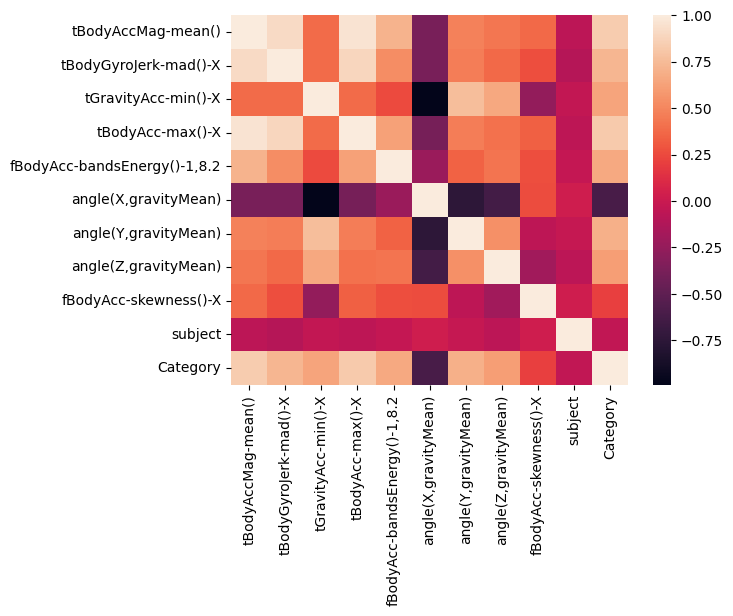

In [62]:
sns.heatmap(df.corr())

## Exploratory Data Analysis

### Задание 5 (0.5 балла)

Вы проверили основную информацию о данных и составили свое первое впечатление о них. Теперь визуализации.

Начнем рисовать графики с небольшой разминки. Выберите две любые математические функции (отличные от линейной) и нарисуйте их на одном графике. Подпишите каждый из графиков, чтобы было понятно, какие функции вы выбрали. Ниже будет пример.

###  (╯°□°)--︻╦╤─

In [91]:
X = np.linspace(-10, 10, 40)
y = 1 / (1 + (np.exp(-X)))
y2 = np.log(X)

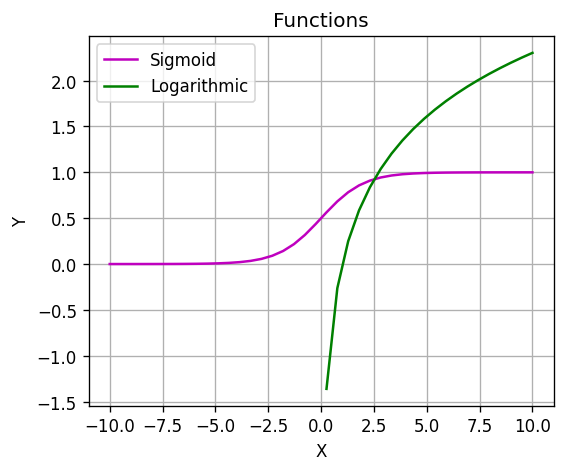

In [100]:
plt.figure(figsize=[5, 4], dpi=120)
plt.plot(X, y, c='m', label='Sigmoid')
plt.plot(X, y2, c='g', label='Logarithmic')

plt.title('Functions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left')
plt.grid()

### Задание 6 (0.5 балла)

Ранее мы уже проверили сбалансированность данных по разным категориям активностей в train и test сетах. Теперь визуализируйте количество сэмплов в каждой из категорий отдельно для train и test сетов, как в примере ниже. Проследите, чтобы порядок категорий слева и справа был одинаков. Иначе не очень удобно их сравнивать (когда они в разных местах двух графиков). Также заметьте, что в примере ось Х в одинаковом масштабе, что тоже удобно для сравнения.

Вам может пригодиться:
- plt.barh или ax.barh

### ' ̿'\̵͇̿̿\з=( ͡ °_̯͡° )=ε/̵͇̿̿/'̿'̿ ̿ 

In [197]:
tr = train['Activity'].value_counts().sort_index()
te = test['Activity'].value_counts().sort_index()
cats = tr.index
cats

Index(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'],
      dtype='object', name='Activity')

In [136]:
max_count = max(max(tr), max(te))

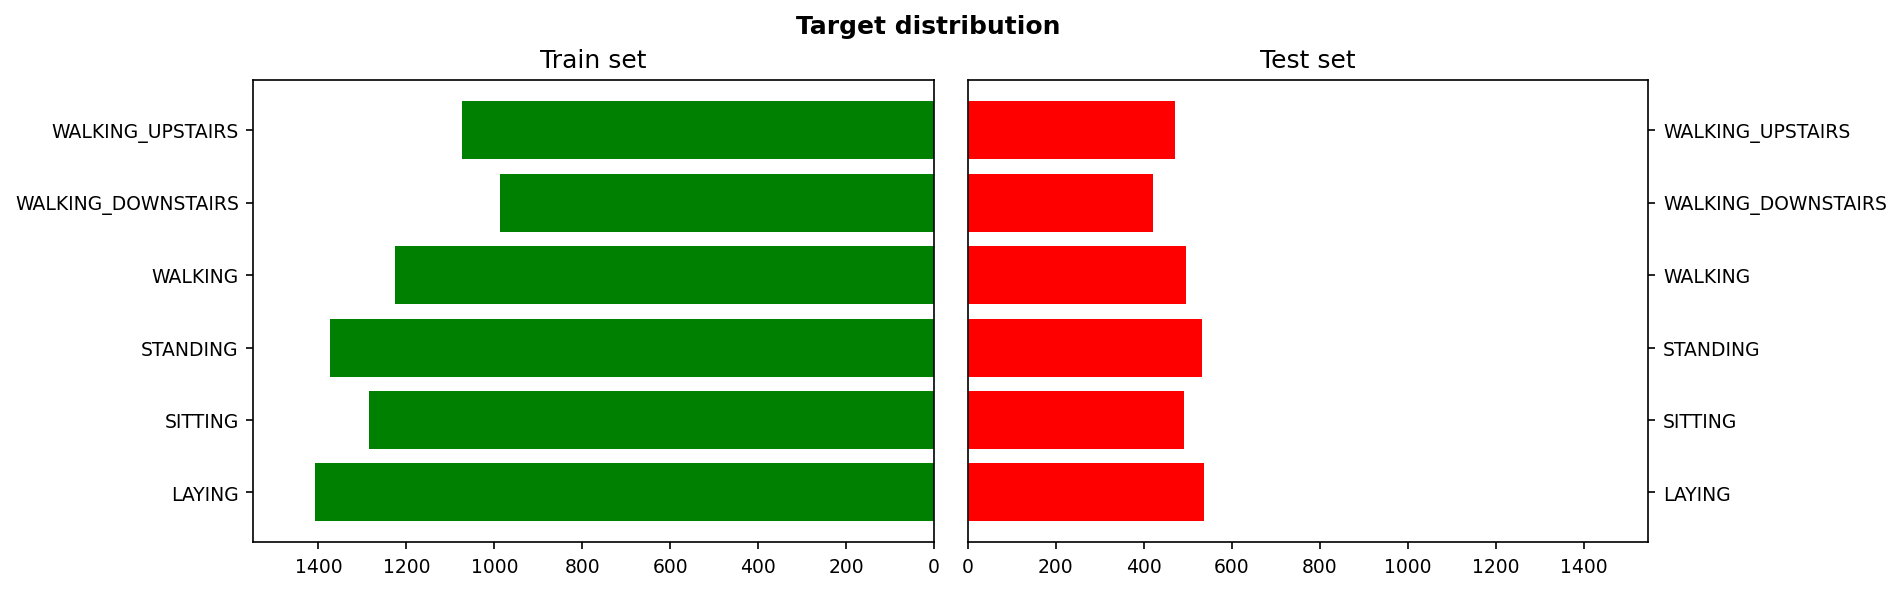

In [204]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12,4], dpi=150)
fig.suptitle('Target distribution', weight='bold', y=0.99)

axes[0].barh(cats, tr, color='g')
axes[0].set_title('Train set')
axes[0].tick_params(axis='x', labelsize=9)
axes[0].tick_params(axis='y', labelsize=9)
axes[0].set_xlim(0, max_count * 1.1)
axes[0].invert_xaxis()

axes[1].barh(cats, te, color='r')
axes[1].set_title('Test set')
axes[1].yaxis.tick_right()
axes[1].tick_params(axis='x', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)
axes[1].set_xlim(0, max_count * 1.1)

plt.subplots_adjust(wspace=0.05)

Правда на таких графиках проще проверять баланс классов таргета?)

### Задание 7 (0.5 балла)

Ранее вы выводили таблицу корреляций. Однако просто таблица корреляций не очень удобна для анализа. Что, если признаков было бы больше? Визуализируйте heatmap корреляций. Подпишите значения корреляций, округленные до 2 знаков после запятой, на графике и оставьте только те значения, которые по модулю не меньше 0.5. Будем считать такие корреляции существенными. Если будете брать код из семинарского ноутбука, то поменяйте в нем что-нибудь, например, цветовую гамму, иначе проверяющий будет карать :)

Какой признак стоит исключить из рассмотрения корреляций? Напишите его название, а также причину, почему нет смысла его рассматривать. 

Вам может пригодиться:
- sns.heatmap
- методы get_text и set_text у атрибута texts графика

### ღゝ◡╹)ノ♡

<Axes: >

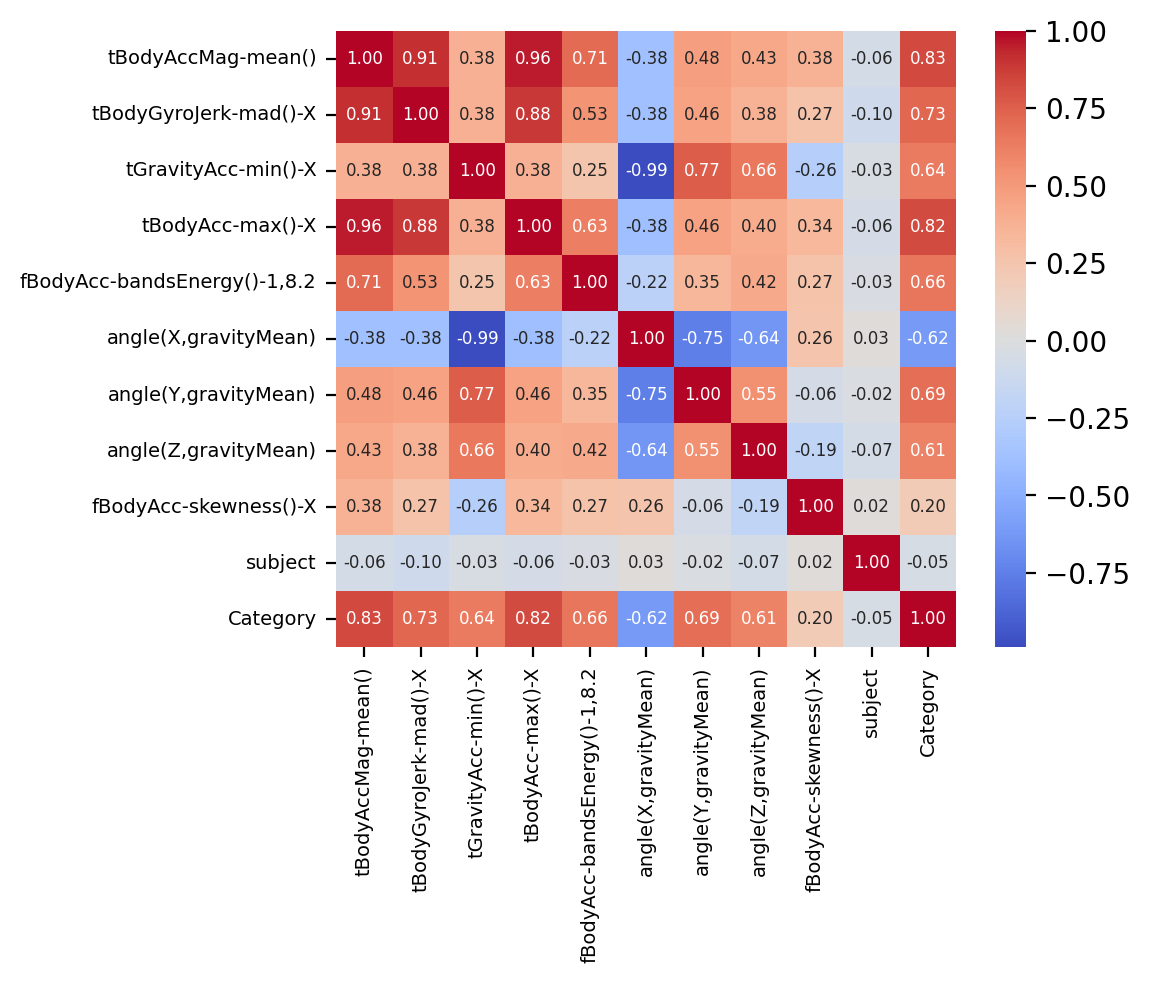

In [229]:
plt.figure(figsize=[5,4], dpi=200)
plt.tick_params(axis='both', labelsize=7)
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f', annot_kws={'size': 6})

### Задание 8 (0.5 балла)

Для начала будем стрелять из пушки по воробьям. Выведите pairplot по всем данным train сета. Напишите, заметили ли вы в нем что-нибудь интересное, чего не было в таблицах и графиках ранее, а также сообщите, было ли вам удобно анализировать 100 графиков. 

### ♪ヽ( ⌒o⌒)人(⌒-⌒ )v ♪

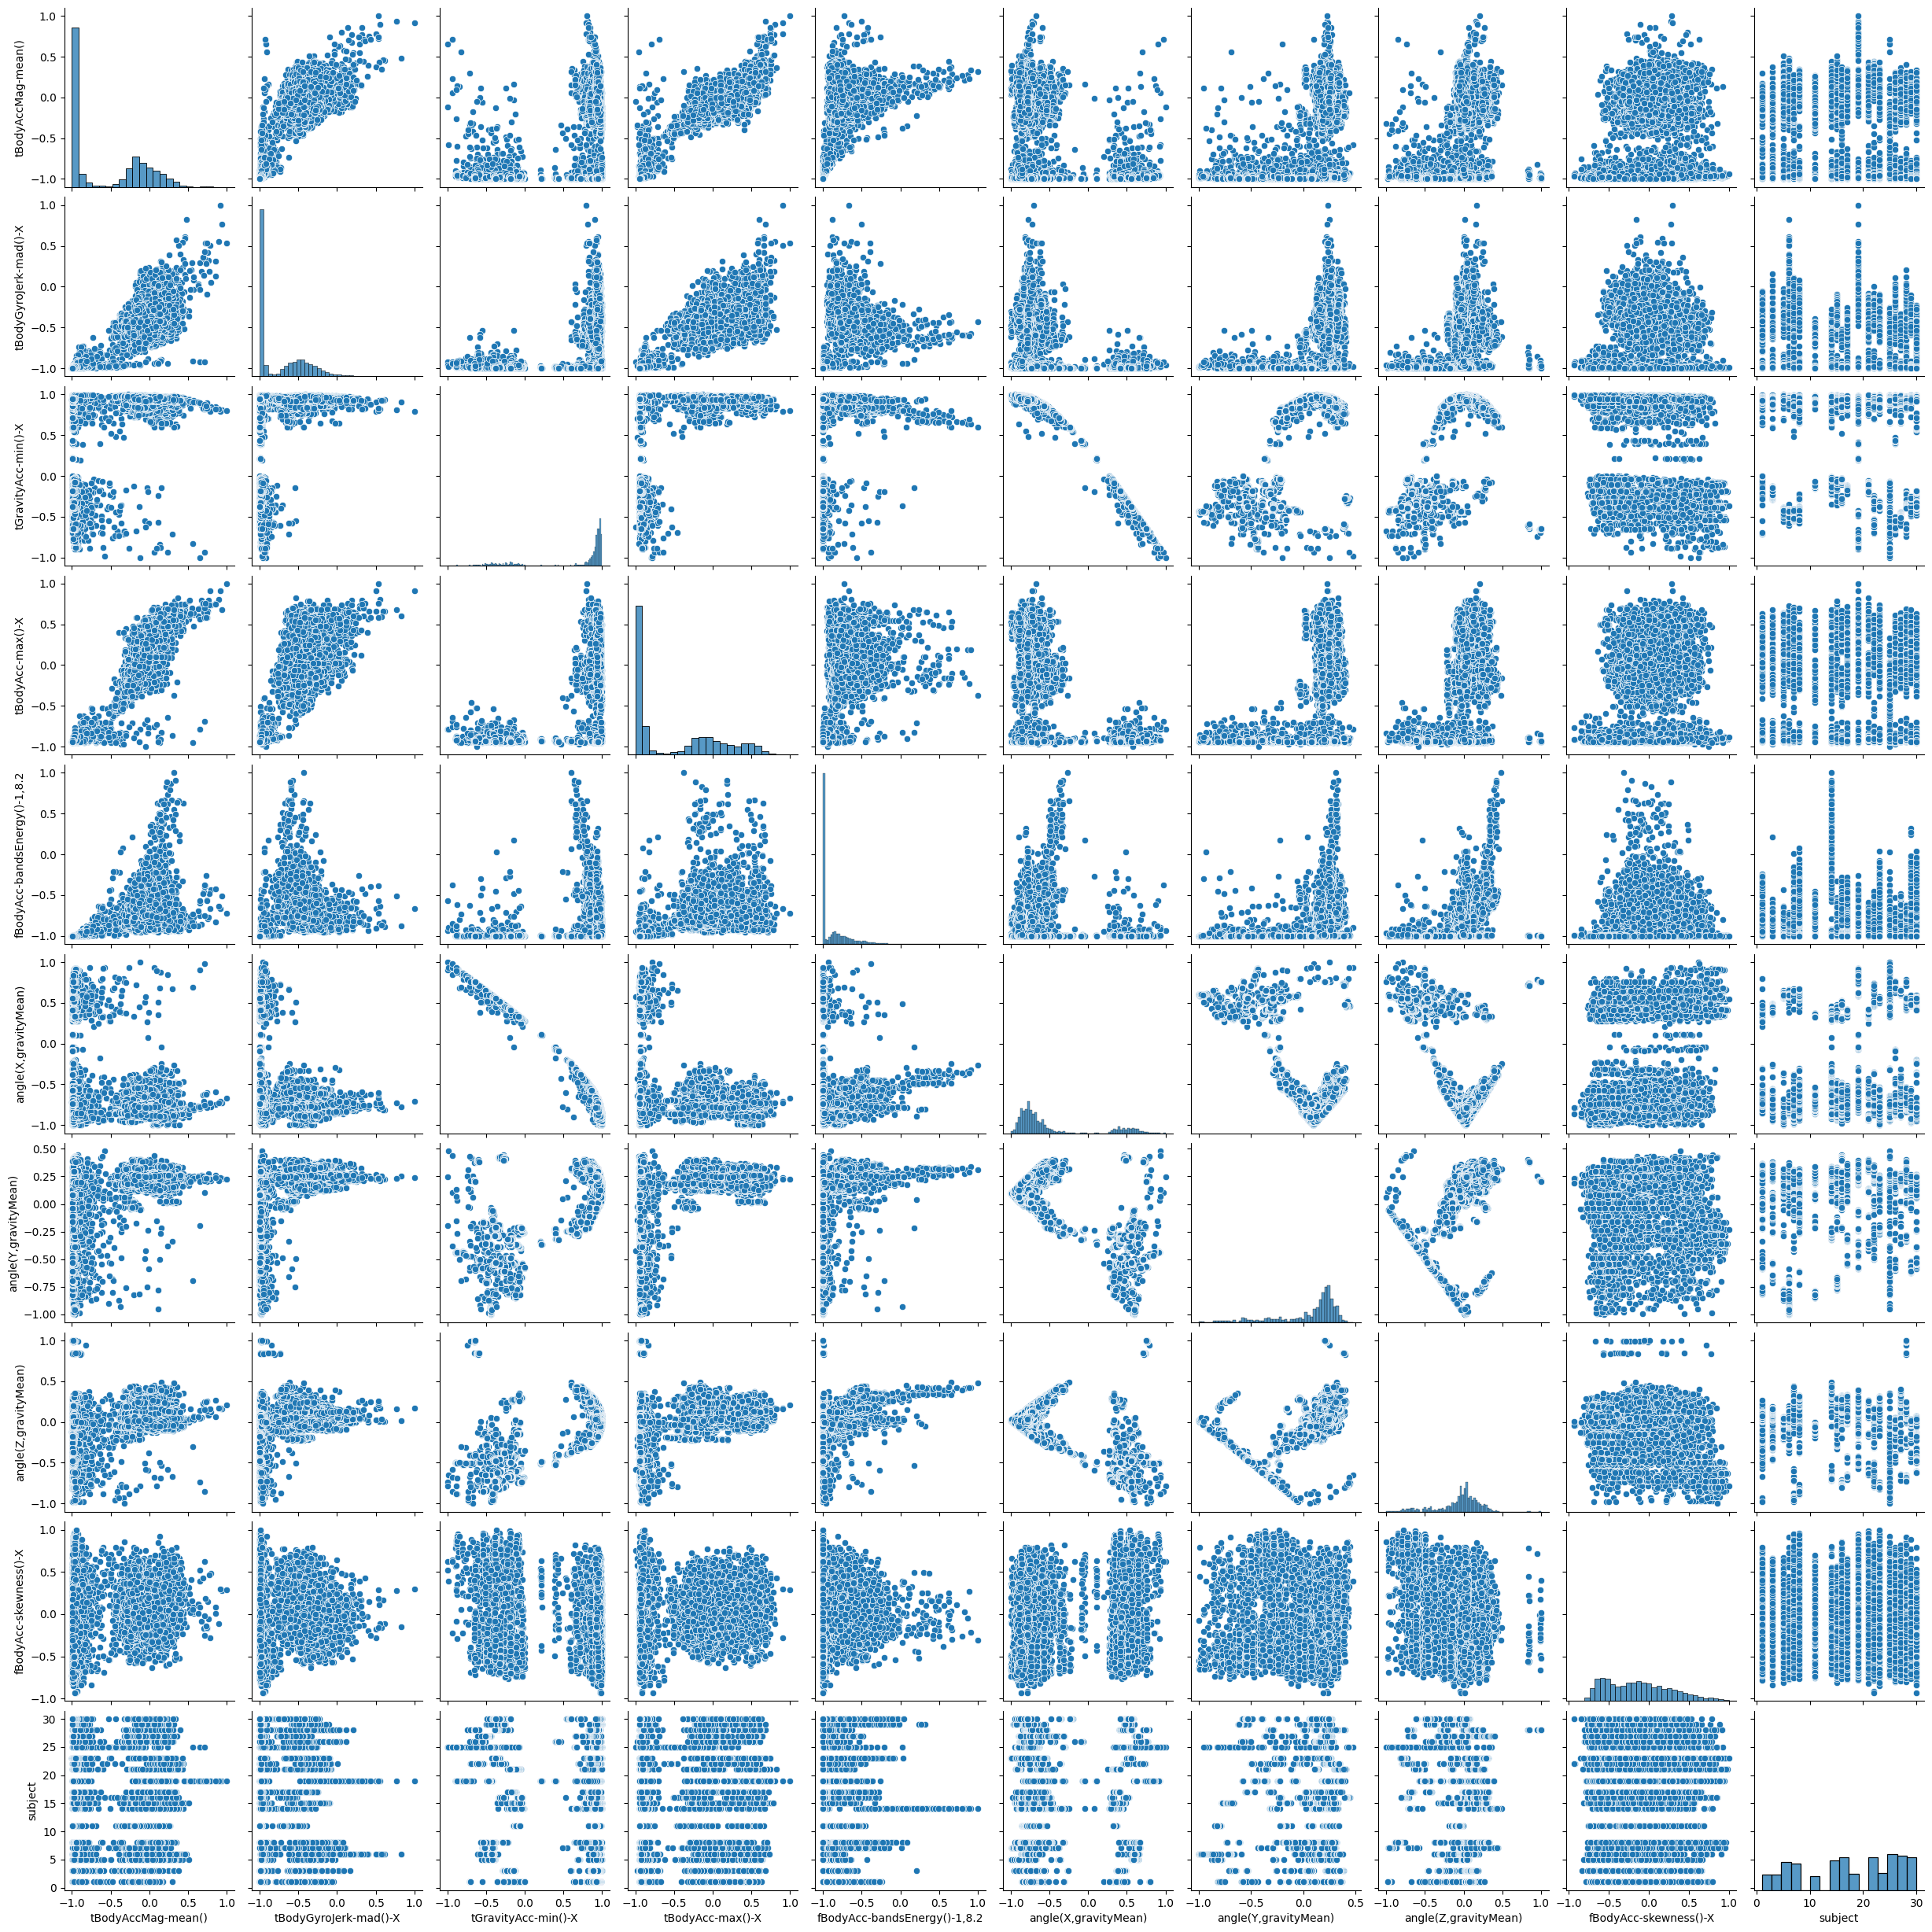

In [230]:
sns.pairplot(train)

Как и раньше видно, что есть достаточно сильные корреляции между признаками. Кстати, вполне наглядно, хоть и мелко!

### Задание 9 (1 балл)

Попробуем проверить гипотезу. Отобразите плотность распределения (kde) `tBodyAccMag-mean()` для каждой из активностей, как в примере ниже. Видите закономерность? Можно ли поделить все активности на две группы? Если да, то проведите вертикальную линию, которая визуально неплохо разделяет эти группы. 

Давайте первую группу называть статическими активностями, а вторую - динамическими. Посчитайте, какую долю правильных ответов дает ваша вертикальная линия для разделения именно этих двух групп.

Вам может пригодиться:
- sns.kdeplot

### ʅ(◔౪◔ ) ʃ

In [24]:
x = df['tBodyAccMag-mean()'].mean()
x

np.float64(-0.5482216597671699)

Text(0, 0.5, 'Density')

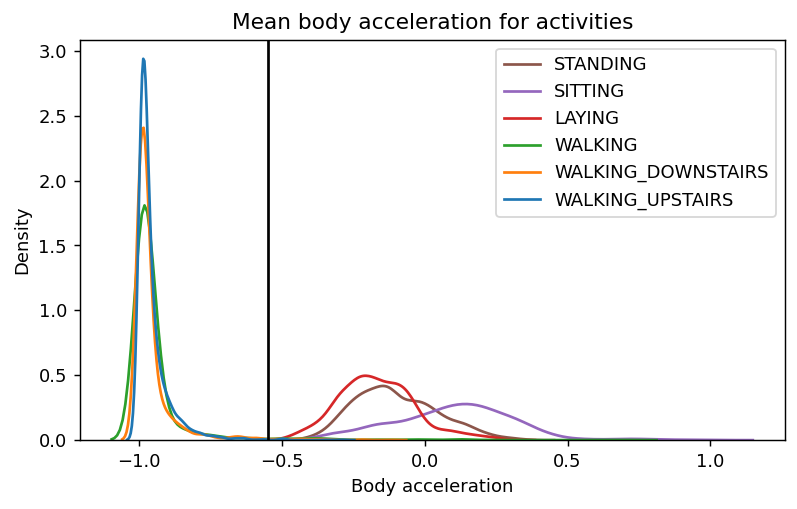

In [32]:
plt.figure(figsize=[7, 4], dpi=130)
sns.kdeplot(data=df, x='tBodyAccMag-mean()', hue='Activity')
plt.axvline(x=x, color='black', label='Mean value')

plt.legend(labels=df['Activity'].unique())
plt.title('Mean body acceleration for activities')
plt.xlabel('Body acceleration')
plt.ylabel('Density')

In [39]:
static = ['STANDING', 'LAYING', 'SITTING']
dynamic = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

df['real_cat'] = df['Activity'].apply(lambda x: 'static' if x in static else 'dynamic')
df['pred_cat'] = df['tBodyAccMag-mean()'].apply(lambda a: 'static' if a < x else 'dynamic')

accuracy = (df['real_cat'] == df['pred_cat']).mean()
accuracy

np.float64(0.9922322555587921)

### Задание 10 (0.5 балла)

Поздравляем, вы проверили первую гипотезу в процессе EDA. Однако нам бы хотелось уметь не группы разделять, а каждый отдельный вид активности. Попробуйте нарисовать "ящики с усами" для `angle(X,gravityMean)` с разделением по разным видам активности на данных train. Можно ли сделать какой-то вывод по полученной визуализации?

Вам может пригодиться:
- sns.boxplot

### ^⨀ᴥ⨀^

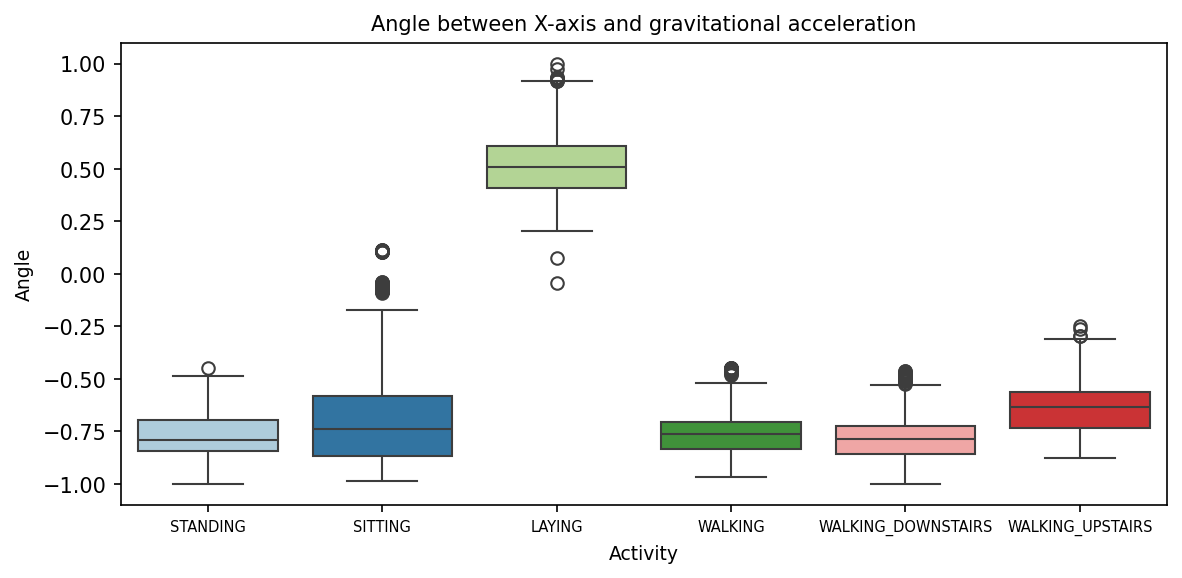

In [63]:
plt.figure(figsize=[9, 4], dpi=150)
sns.boxplot(data=train, x='Activity', y='angle(X,gravityMean)', palette='Paired')

plt.title('Angle between X-axis and gravitational acceleration', fontsize=10)
plt.xlabel('Activity', fontsize=9)
plt.ylabel('Angle', fontsize=9)
plt.xticks(fontsize=7);

### Задание 11 (0.5 балла)

Посмотрим теперь на `tBodyAcc-max()-X`. Визуализируйте скрипичные диаграммы для этого признака с разделением по активностям на всем train. Кажется логичным, что максимальное ускорение в моменте для разных активностей будет различаться.

Вам может пригодиться:
- sns.violinplot

### ( ͡☉ ͜ʖ ͡☉)

Text(0.5, 1.0, 'Maximal body acceleration over activities')

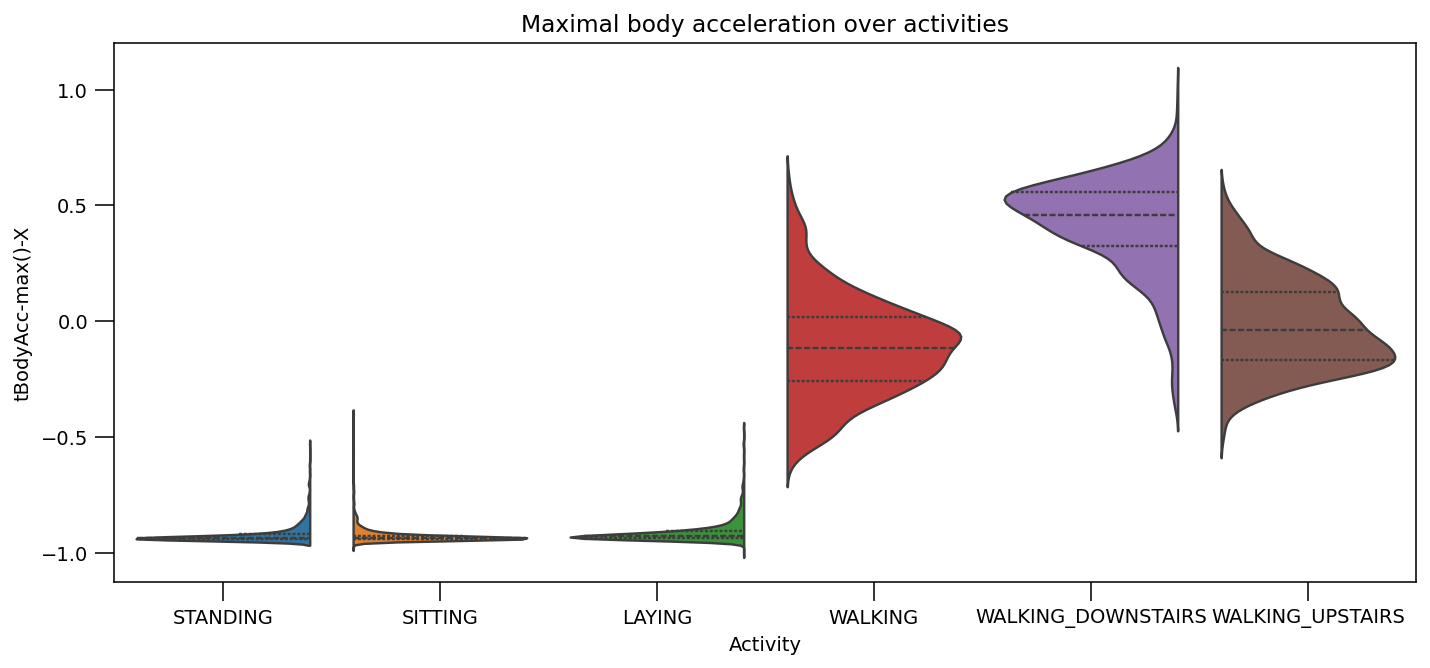

In [87]:
plt.figure(figsize=[12, 5], dpi=140)
sns.violinplot(data=df, x='Activity', y='tBodyAcc-max()-X', hue='Activity', split=True, inner='quartile')

plt.tick_params(axis='both', size=10)
plt.title('Maximal body acceleration over activities')

### Задание 12 (1 балл)

Вы уже можете с довольно хорошим качеством выделить две категории активности из шести. Продолжим. 

Ранее уже упоминалось разделение на две группы активностей: статические и динамические. Пришла пора разделить датасет на две части. Сделайте это! Теперь на одной картинке покажите распределения `fBodyAcc-bandsEnergy()-1,8.2` для динамичных активностей (boxenplot - немного измененый "ящик с усами") и `angle(Y,gravityMean)` для статических - тут хватит и простой гистограммы (прямо, как в примере ниже).

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec (заметили, что один график больше другого? попробуйте сами так сделать - вам понравится...)
- sns.boxenplot
- sns.histplot

### ‿( ́ ̵ _-`)‿ 

In [98]:
s = df[df['real_cat'] == 'static']
d = df[df['real_cat'] == 'dynamic']

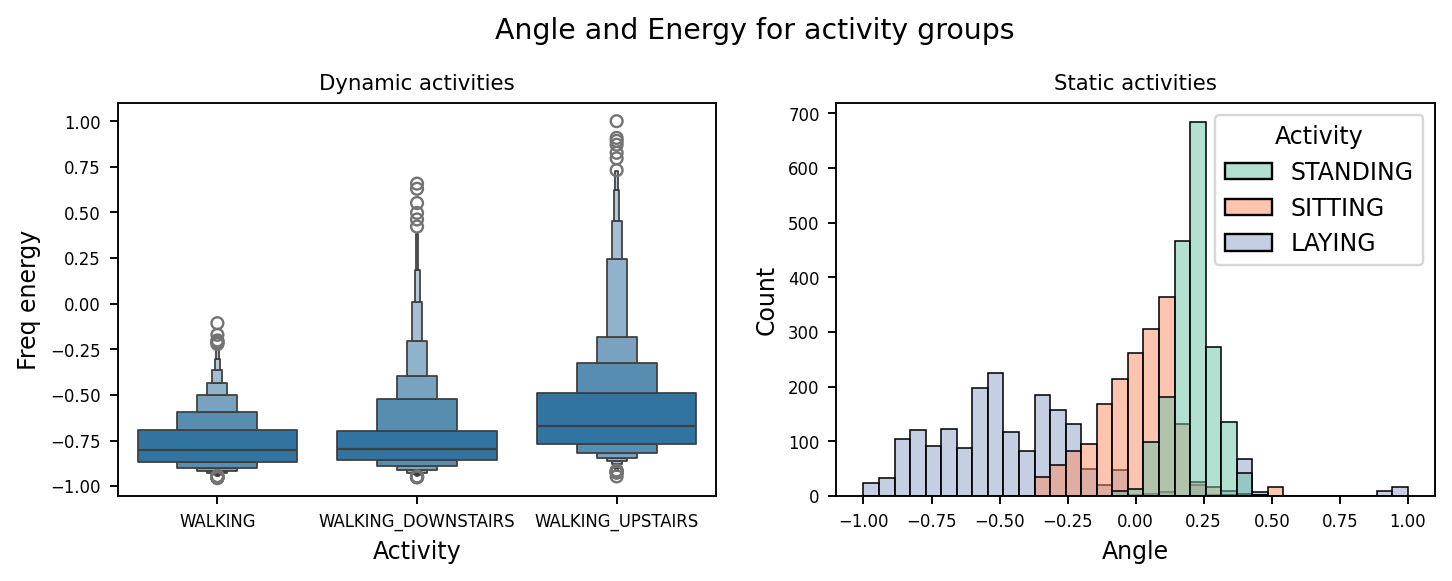

In [159]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=170)

sns.boxenplot(data=d, x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2', ax=axis[0])
axis[0].tick_params(axis='both', labelsize=7)
axis[0].set_title('Dynamic activities', size=9)
axis[0].set_xlabel('Activity')
axis[0].set_ylabel('Freq energy')

sns.histplot(data=s, x='angle(Y,gravityMean)', palette='Set2', ax=axis[1], hue='Activity')
axis[1].tick_params(axis='both', labelsize=7)
axis[1].set_title('Static activities', size=9)
axis[1].set_xlabel('Angle')
axis[1].set_ylabel('Count')

plt.suptitle('Angle and Energy for activity groups', size=12, y=1.05);

### Задание 13 (0.5 балла)

Не всегда жизнь будет такой легкой, а данные будут полностью или почти линейно разделимы в одному признаку (иначе чем бы занимались дата саентисты...). Часто данные вообще ни по одному признаку нельзя адекватно разделить (да и по комбинациям признаков тоже). Давайте попробуем взять не один признак, а целых два! 

Рассмотрим только статические активности. Будет снова два графика сразу. На первом графике будет боксплот распределения `fBodyAcc-skewness()-X` по активностям. А на втором попробуем взять не все наблюдения данной группы активностей, а только их часть. Разделимы ли категории по `fBodyAcc-skewness()-X`? А если взять только те строки, где `fBodyAcc-skewness()-X < -0.376`, и теперь вывести боксплот распределения `angle(Y,gravityMean)` по разным активностям?

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec
- sns.boxplot

### (ಠ_ಠ)

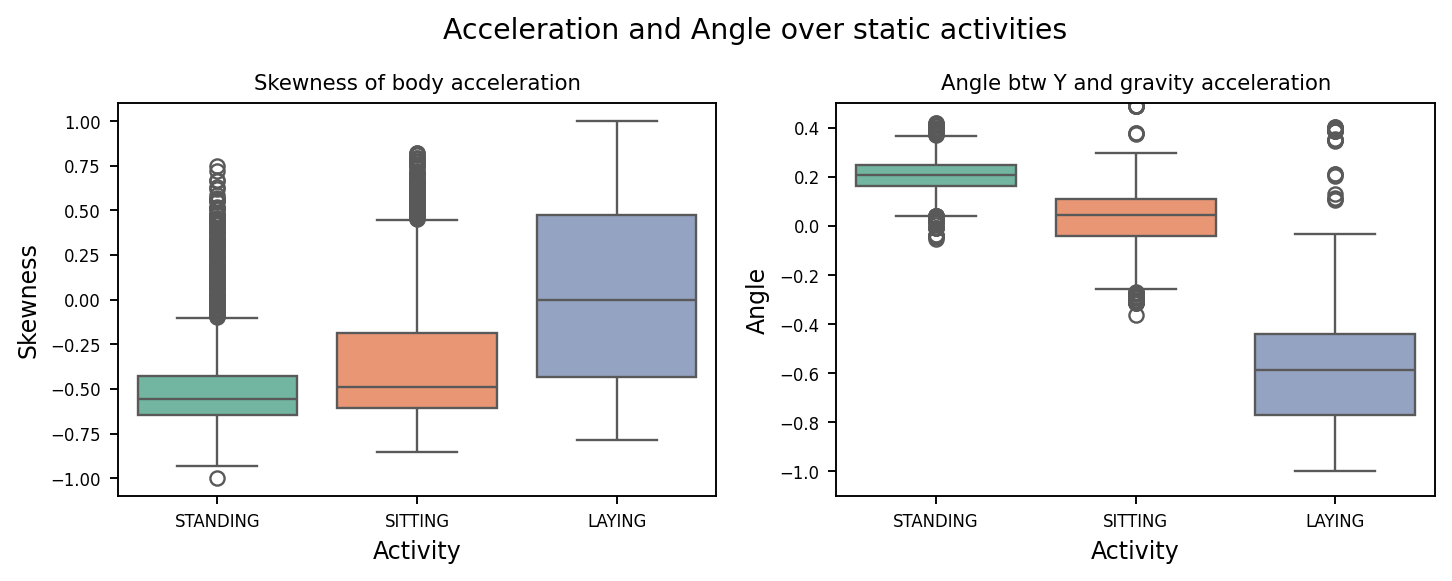

In [165]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=170)

sns.boxplot(data=s, x='Activity', y='fBodyAcc-skewness()-X', palette='Set2', ax=axis[0])
axis[0].tick_params(axis='both', labelsize=7)
axis[0].set_title('Skewness of body acceleration', size=9)
axis[0].set_xlabel('Activity')
axis[0].set_ylabel('Skewness')

new_s = s[s['fBodyAcc-skewness()-X'] < -0.376]
sns.boxplot(data=new_s, x='Activity', y='angle(Y,gravityMean)', palette='Set2', ax=axis[1])
axis[1].tick_params(axis='both', labelsize=7)
axis[1].set_title('Angle btw Y and gravity acceleration', size=9)
axis[1].set_xlabel('Activity')
axis[1].set_ylabel('Angle')
axis[1].set_ylim(-1.1, 0.5)

plt.suptitle('Acceleration and Angle over static activities', size=12, y=1.05);

Поздравляем, теперь вы на шажок ближе к тому, чтобы стать решающим деревом!

### Задание 14 (1 балл)

Выделить оставшуюсь категорию с хорошим качеством не так уж и просто. Из доступных признаков, сначала посмотрите на распределение `tBodyAcc-max()-X` на динамических активностях (скрипичная диаграмма отлично подойдет). 

А теперь спускаем вам порог `tBodyAcc-max()-X < 0.157`. Для таких строк постройте диаграмму рассеяния для признака `tGravityAcc-min()-X`.

Вам может пригодиться:
- plt.subplots или matplotlib.gridspec
- sns.violinplot
- sns.swarmplot (иногда лучше подходит, чем просто sns.scatterplot)

Обратите внимание, что подписи к осям можно убирать методами plt. Например, если у вас общее название для оси Y для обоих графиков, то можно не подписывать ось Y у второго графика.

### (✖╭╮✖)

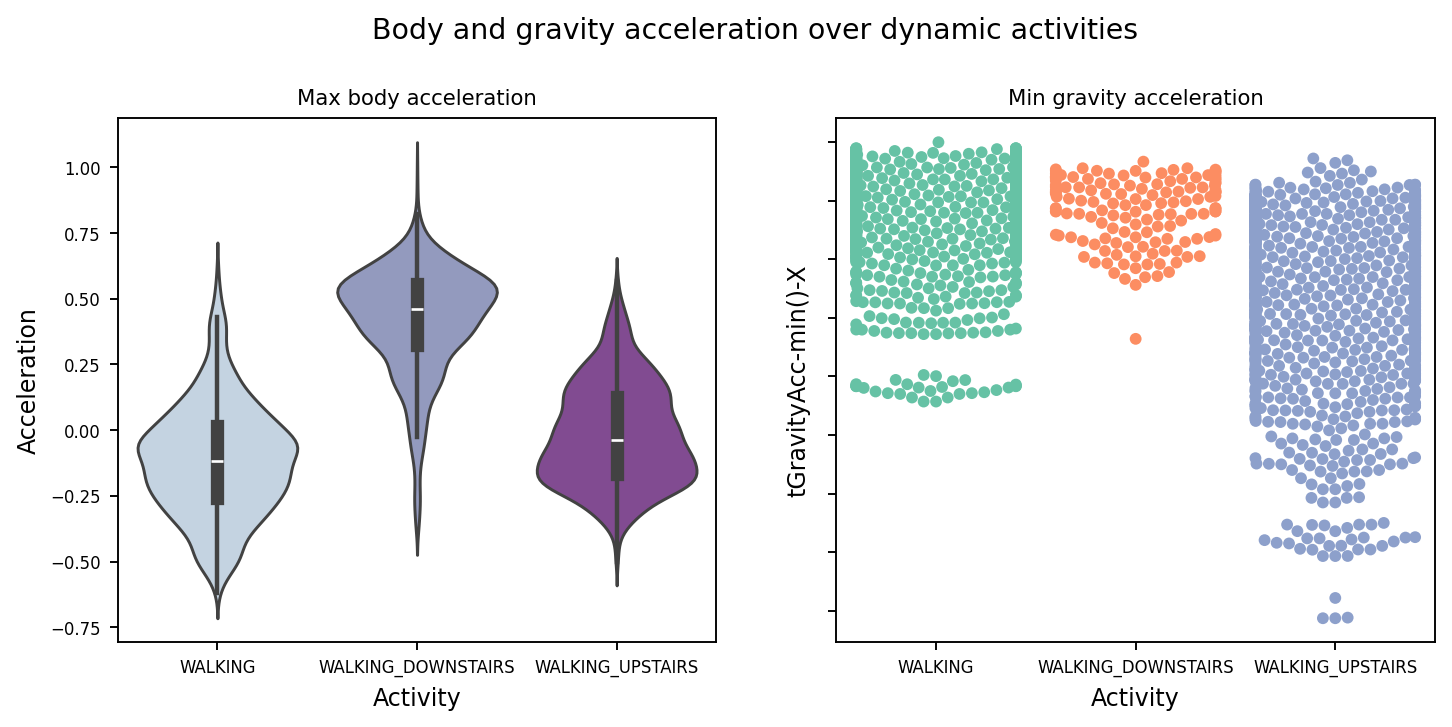

In [188]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=170)

sns.violinplot(data=d, x='Activity', y='tBodyAcc-max()-X', palette='BuPu', ax=axis[0])
axis[0].tick_params(axis='both', labelsize=7)
axis[0].set_title('Max body acceleration', size=9)
axis[0].set_xlabel('Activity')
axis[0].set_ylabel('Acceleration')

new_d = d[d['tBodyAcc-max()-X'] < 0.157]
sns.swarmplot(data=new_d, x='Activity', y='tGravityAcc-min()-X', palette='Set2', ax=axis[1])
axis[1].tick_params(axis='both', labelsize=7)
axis[1].set_title('Min gravity acceleration', size=9)
axis[1].set_xlabel('Activity')
axis[1].set_yticklabels([])

plt.suptitle('Body and gravity acceleration over dynamic activities', size=12, y=1.03);

### Задание 15 (0.5 балла)

Теперь попробуем более интерактивные графики. Установите библиотеку `plotly` (обычно `pip install plotly` или `conda install plotly`). Синтаксис очень похож на `seaborn`, но вот [документация для plotly.express](https://plotly.com/python-api-reference/plotly.express.html). 

Сначала подготовим данные для визуализации. Будем считать t-SNE просто "черным ящиком", который принимает наши данные и проецирует их в двумерное или трехмерное пространство. Возможно, придется немного подождать.

In [29]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=666, n_components=2)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_2_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y']),
    train['Activity']
], axis=1)

tsne = TSNE(random_state=666, n_components=3)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_3_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

CPU times: total: 15min 41s
Wall time: 58.2 s


Теперь нарисуйте scatter-график через `plotly.express` для `df_2_comp` с выделением цветами активностей. Красиво получилось? Видны скопления точек одного цвета? Можно разные активности отделить линиями на данном графике?

In [ ]:
# ʅ(◔౪◔ ) ʃ your code here

Мы не отстаем от трендов и тоже можем в 3D. Сейчас и вы научитесь (если еще не умеете). Нарисуйте scatter_3d-график через `plotly.express` для `df_3_comp` с выделением цветами активностей. Повращайте его. Нормально получилось? Есть ли какая-то структура у точек?

In [ ]:
# (✧≖‿ゝ≖) your code here

### Задание 16 (1 балл)

Мы сделали вам fit. Ваша очередь сделать predict. Допишите функцию, которая принимает на вход датафрейм с признаками, а выдает вектор из предсказаний - для каждой строки датафрейма вы определяете, к какому классу принадлежит объект. Рекомендуем сразу записывать из строками, а не кодировать в числа. Дальше фукнция `accuracy_score` выдаст вам долю правильных ответов.

Подсказка: вы уже отделили категории друг от друга по каким-то признакам. Воспользуйтесь этим знанием! Используя только проведенный вами анализ можно спокойно выбить не менее 75% на train и test! Если вы получите меньше 75%, то балл будет снижен. Авторское решение (на основе всех графиков выше) выбивает 81% и 77% на train и test соответственно. [Шапргалка с готовыми идеями для такой задачи](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

In [34]:
def predict(df: pd.DataFrame):
    # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ your code here
    pass

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [33]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.8109357997823722
Accuracy on test set => 0.7757041058703766


__Место для мема и/или фидбэка__